In [6]:
# load attention map
import json
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from skimage.draw import polygon

def load_score_map(score_map_path):
    with open(score_map_path, 'r') as f:
        score_map = json.load(f)
    return score_map


def load_crop_scores(crop_scores_path):
    with open(crop_scores_path, 'r') as f:
        crop_scores = json.load(f)
    return crop_scores


def visualize_attention_map(score_map, original_image_path, save=False, save_path=None, image_size=(336, 336)):

    image = Image.open(original_image_path)
    image = image.resize(image_size)
    plt.imshow(image)
    plt.imshow(score_map, cmap='hot', alpha=0.5)
    plt.axis('off')
    if save:
        # plt.colorbar(shrink=0.95)  # Shrink the colorbar to half its default size
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=300)
    else:
        plt.colorbar()
        plt.show()


def get_score_map(crop_scores,
                  attention_method='first_token',
                  image_size=(336, 336),
                  crop_size=(28, 28),
                  desired_ans_scores=None,
                  min_len=None):
    
    attention_map = np.zeros((image_size[0]//crop_size[0], image_size[0]//crop_size[0]))
    for crop_score in crop_scores:
        x, y = crop_score['crop_position']
        if attention_method == "first_token":
            attention_map[y // crop_size[0], x // crop_size[0]] = abs(crop_score['scores'][0] - desired_ans_scores[0])
        elif attention_method == "mean":
            if min_len is not None:
                min_length = min(len(crop_score['scores']), len(desired_ans_scores), min_len)
            else:
                min_length = min(len(crop_score['scores']), len(desired_ans_scores))
            for i in range(min_length):
                attention_map[y // crop_size[0], x // crop_size[0]] += abs(crop_score['scores'][i] - desired_ans_scores[i])
            attention_map[y // crop_size[0], x // crop_size[0]] /= min_length

    return attention_map


def get_response(model_output_dir, id, chart_type):
    crop_scores_path = os.path.join(model_output_dir, id, f'{chart_type}_crop_scores.json')
    crop_scores = load_crop_scores(crop_scores_path)
        
    for crop_score in crop_scores:
        if crop_score['original']:
            response = crop_score['response']
            return response
    return None

def calculate_score_map(model_output_dir, id, chart_type, only_top_n, crop_size, score_threshold=0.1):
    crop_scores_path = os.path.join(model_output_dir, id, f'{chart_type}_crop_scores.json')
    crop_scores = load_crop_scores(crop_scores_path)
        
        
    # response = crop_scores[0]['response']
    # print("response:", response)        
    for crop_score in crop_scores:
        if crop_score['original']:
            desired_ans_scores = crop_score['scores']
            # response = crop_score['response']

    # alternatively, we get the score map by crop_scores
    if desired_ans_scores is not None:
        raw_score_map = get_score_map(crop_scores, desired_ans_scores=desired_ans_scores)
    else:
        print("Ops, we may not have desired_ans_scores")
        score_map_path = os.path.join(model_output_dir, id, f'{chart_type}_score_map.json')
        raw_score_map = load_score_map(score_map_path)
    
    # show top and normalize
    top_n_indexes = np.argsort(raw_score_map.flatten())[-only_top_n:]
    for i in range(raw_score_map.size):
        if i not in top_n_indexes:
            raw_score_map[i // raw_score_map.shape[0], i % raw_score_map.shape[0]] = 0

    # set the score map to 0 if the score is less than the score_threshold
    # raw_score_map[raw_score_map < score_threshold] = 0
    
    # find the minimum non-zero number
    # non_zero_min = np.min(raw_score_map[raw_score_map != 0])
    
    # replace zeros with the minimum non-zero value
    # raw_score_map[raw_score_map == 0] = non_zero_min
    # normalize to [0, 1]
    score_map = (raw_score_map - raw_score_map.min()) / raw_score_map.max()
    # print("score_map.min():", score_map.min())
    # print("score_map.max():", score_map.max())
    # set the score map to 0 if the score is less than the score_threshold
    # print("Before:", score_map)
    score_map[score_map < score_threshold] = 0
    # print("After:", score_map)
    # print("score_map.min():", score_map.min())
    # print("score_map.max():", score_map.max())
    
    score_map_resized = np.kron(score_map, np.ones((crop_size[0], crop_size[0])))

    return score_map_resized


original_data_path = './data/annotated_importance_heatmap'

# model_output_dir = './output/internvl_awq_prob_output'
model_output_dir = './output/phi3_prob_output'

ids = os.listdir(model_output_dir)

only_top_n = 144
# only_top_n = 60
# only_top_n = 80
# image_size = (336, 336)
# crop_size = (28, 28)
image_size = (672, 672)
crop_size = (56, 56)

score_threshold = 0.1

# for id in ids:
#     # get question
#     # skip .DS_Store
#     if id == '.DS_Store' or len(os.listdir(os.path.join(original_data_path, id))) < 2:
#         continue

#     task_list = json.load(open(os.path.join(original_data_path, id, f'{id}.task.json')))
#     task_list = task_list[0]
#     # find the first Retrieve-Value task.
#     for task in task_list:
#         if task['type'] == 'Retrieve Value':
#             question = task['description']
#             break
#     # print("ID:", id, "Question:", question)
#     # for chart_type in ['bar_anno']:
#     # for chart_type in ['bar', 'bar_anno']:
#     for chart_type in ['bar']:
#         # print("Running on id:", id, "chart_type:", chart_type)
#         original_image_path = os.path.join(original_data_path, id, f'{id}_{chart_type}.png')
#         score_map_resized = calculate_score_map(model_output_dir, id, chart_type, only_top_n, crop_size, score_threshold)
#         response = get_response(model_output_dir, id, chart_type)
#         # print("response:", response)
#         # print("score_map_resized.shape", score_map_resized.shape)
#         # visualize_attention_map(score_map_resized, original_image_path)

#         # visualize_attention_map(score_map_resized, original_image_path, save=False, save_path=os.path.join(model_output_dir, id, f'{chart_type}_score_map.png'), image_size=image_size)

#     # print("="*100)
#     # break


In [7]:

# model_output_dir = 'internvl_awq_prob_output'
# # model_output_dir = 'phi3_prob_output'
# ids = os.listdir(model_output_dir)

# # ids =  ['878']
# finish_cnt = 0
# for id in ids:
#     if id == '.DS_Store' or len(os.listdir(os.path.join(model_output_dir, id))) < 5:
#         continue
#     finish_cnt += 1

# print("finish_cnt:", finish_cnt)


In [8]:
# load the annotated important regions.

# ids = ['11', '13', '19']
# ids = ['1283']
# ids = ['486']
# ids = os.listdir(model_output_dir)
# ids = ['1614']

def load_important_regions(id, chart_type):
    with open(os.path.join(original_data_path, id, f'{id}_{chart_type}.json'), 'r') as f:
        important_regions = json.load(f)
    return important_regions


def resize_polygon(points, original_size, new_size):
    original_width, original_height = original_size
    new_width, new_height = new_size
    
    # Calculate scaling factors
    x_scale = new_width / original_width
    y_scale = new_height / original_height
    
    # Scale each point
    new_points = [[int(x * x_scale), int(y * y_scale)] for x, y in points]
    
    return new_points

results_dict = {}

for id in ids:
    if id == '.DS_Store':
        continue

    results_dict[id] = {}

    task_list = json.load(open(os.path.join(original_data_path, id, f'{id}.task.json')))
    task_list = task_list[0]
    # find the first Retrieve-Value task.
    for task in task_list:
        if task['type'] == 'Retrieve Value':
            question = task['description']
            break

    # for chart_type in ['bar_anno', 'bar']:
    for chart_type in ['bar', 'bar_anno']:
    # for chart_type in ['bar']:
        important_regions = load_important_regions(id, chart_type)
        # print(important_regions)
        original_size = (important_regions['imageWidth'], important_regions['imageHeight'])
        new_size = image_size

        for shape in important_regions['shapes']:
            resized_points = resize_polygon(shape['points'], original_size, new_size)
            shape['resized_points'] = resized_points


        # calculate whether the annotatedregions are covered 60% by the attention map
        score_map_resized = calculate_score_map(model_output_dir, id, chart_type, only_top_n, crop_size, score_threshold)
        # print("score_map_resized.shape", score_map_resized.shape)

        response = get_response(model_output_dir, id, chart_type)
        important_region_matrix = np.zeros(image_size)
        polygon_area = 0
        all_rr, all_cc = [], []

        
        for shape in important_regions['shapes']:
            points = np.array(shape['resized_points'])
            rr, cc = polygon(points[:, 1], points[:, 0], image_size)
            important_region_matrix[rr, cc] = 1
            all_rr.extend(rr)
            all_cc.extend(cc)
            polygon_area += len(rr)

        # if chart_type == 'bar_anno':
        #     from skimage.draw import polygon, line
        #     # Function to connect two points
        #     def connect_points(p1, p2):
        #         rr, cc = line(p1[1], p1[0], p2[1], p2[0])
        #         important_region_matrix[rr, cc] = 1

        #     # Draw and connect all shapes
        #     for shape in important_regions['shapes']:
        #         points = np.array(shape['resized_points'])
                
        #         # Fill the polygon
        #         rr, cc = polygon(points[:, 1], points[:, 0], important_region_matrix.shape)
        #         important_region_matrix[rr, cc] = 1
                
        #         # Connect the points of the polygon
        #         for i in range(len(points)):
        #             connect_points(points[i], points[(i+1) % len(points)])

        #     # Connect shapes to each other
        #     all_points = [point for shape in important_regions['shapes'] for point in shape['resized_points']]
        #     for i, p1 in enumerate(all_points):
        #         for p2 in all_points[i+1:]:
        #             connect_points(p1, p2)

        #     # Calculate area and get coordinates
        #     polygon_area = np.sum(important_region_matrix)
        #     all_rr, all_cc = np.where(important_region_matrix > 0)

        attention_map_area = score_map_resized[all_rr, all_cc]

        # Calculate the ratio of covered area
        covered_area = np.sum((important_region_matrix[all_rr, all_cc] == 1) & (attention_map_area > 0))
        ratio = covered_area / polygon_area if polygon_area > 0 else 0
        # print("ID:", id, "Chart Type:", chart_type, "Ratio:", ratio)
        # if ratio >= 0.5:
        #     print(f"Important regions are covered by the attention map")
        # else:
        #     print(f"Important regions are not covered by the attention map")

        results_dict[id][chart_type] = {'question': question, 'ratio': ratio, 'response': response}

print(results_dict)

{'1007': {'bar': {'question': 'How many employees are there in the Utilities (total) category?', 'ratio': 0.748653265011168, 'response': '190,000<|end|><|endoftext|>'}, 'bar_anno': {'question': 'How many employees are there in the Utilities (total) category?', 'ratio': 0.3589842924561527, 'response': '188834<|end|><|endoftext|>'}}, '1025': {'bar': {'question': 'Determine the youth unemployment rate in the year 2000.', 'ratio': 0.8948825157529003, 'response': '0.06<|end|><|endoftext|>'}, 'bar_anno': {'question': 'Determine the youth unemployment rate in the year 2000.', 'ratio': 0.8145397076254445, 'response': '0.061<|end|><|endoftext|>'}}, '1039': {'bar': {'question': 'Determine the number of properties purchased by Blackstone.', 'ratio': 0.819350195352663, 'response': '250<|end|><|endoftext|>'}, 'bar_anno': {'question': 'Determine the number of properties purchased by Blackstone.', 'ratio': 1.0, 'response': '261<|end|><|endoftext|>'}}, '1060': {'bar': {'question': 'What is the net mig

In [10]:
# # save the results_dict to a json file

if model_output_dir == './output/internvl_awq_prob_output':  
    # save the results_dict to a json file
    with open('./output/internvl_prob_results_dict.json', 'w') as f:
        json.dump(results_dict, f, indent=4)

elif model_output_dir == './output/phi3_prob_output':
    # save the results_dict to a json file
    with open('./output/phi3_prob_results_dict.json', 'w') as f:
        json.dump(results_dict, f, indent=4)

In [116]:
# # important_region_matrix
# # plot the important_region_matrix
# plt.figure(figsize=(5, 5))
# original_image = Image.open(os.path.join(original_data_path, id, f'{id}_{chart_type}.png'))
# original_image = original_image.resize(image_size)
# plt.imshow(original_image)
# plt.imshow(important_region_matrix, cmap='hot', alpha=0.5)
# # plt.imshow(score_map, , alpha=0.5)
# plt.axis('off')
# # save

# plt.savefig(id+"_"+chart_type+"_annotated_region", bbox_inches='tight', pad_inches=0, dpi=300)
# # plt.show()
# # plt.figure(figsize=(5, 5))


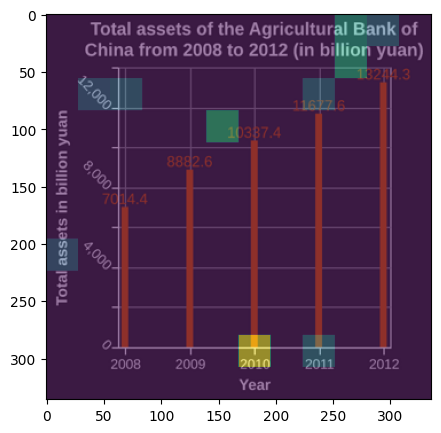

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [194]:
# # important_region_matrix
# # plot the important_region_matrix
# plt.figure(figsize=(5, 5))
# original_image = Image.open(os.path.join(original_data_path, id, f'{id}_{chart_type}.png'))
# original_image = original_image.resize((336, 336))
# plt.imshow(original_image)
# plt.imshow(score_map_resized, alpha=0.5)
# plt.show()
# plt.figure(figsize=(5, 5))


In [72]:
important_region_matrix.shape

(336, 336)

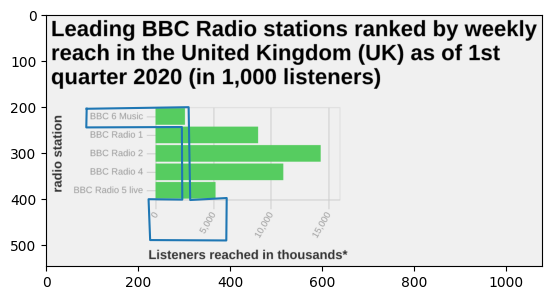

In [46]:
# # plot the original image and original points
# # plt.figure(figsize=(5, 5))
# original_image = Image.open(os.path.join(original_data_path, id, f'{id}_{chart_type}.png'))
# plt.imshow(original_image)

# for shape in important_regions['shapes']:
#     # to connect 
#     to_conenect_a = [p[0] for p in shape['points']] + [shape['points'][0][0]]
#     to_conenect_b = [p[1] for p in shape['points']] + [shape['points'][0][1]]
#     plt.plot(to_conenect_a, to_conenect_b, label=shape['label'])
#     # connect the first and last point
#     # plt.plot([shape['points'][-1][0], shape['points'][0][0]], [shape['points'][-1][1], shape['points'][0][1]], label=shape['label'])
# # plt.legend()
# plt.show()